# Synthetic Data (Poisson-Log-Normal)

In [2]:
import torch
import numpy 
import matplotlib.pyplot as plt

import pyro
import pyro.poutine as poutine
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta
from torch.distributions import constraints

### Generate fake data and visualize

In [3]:
def generate_fake_data(X_nl, g, k=1, alpha_scale=1E-2, alpha0_loc=-6.0, alpha0_scale=0.5, noise_scale=1E-2):
    """
    Args:
        X_nl: design matrix (with the covariates)
        g: int, number of genes
        k: int, number of cell types
        alpha_scale: scale for alpha
        alpha0_loc: loc of alpha0
        alpha0_scale: scale for alpha0
        noise_scale: noise scale
    """
    n, l = X_nl.shape[:2]
    cell_ids_n = torch.randint(low=0, high=k, size=[n])
    total_umi_n1 = torch.randint(low=250, high=3000, size=[n,1])
    alpha_klg = alpha_scale * torch.randn((k,l,g))
    alpha0_kg = alpha0_loc + alpha0_scale * torch.randn((k,g))
    eps_g = torch.randn(g) * noise_scale  # std per gene
    eps_ng = torch.randn(n,g) * eps_g
    
    log_mu_ng = alpha0_kg[cell_ids_n] + (X_nl[...,None] * alpha_klg[cell_ids_n]).sum(dim=-2) 
    mu_ng = (log_mu_ng + eps_ng).exp()
    rate_ng = total_umi_n1 * mu_ng
    counts_ng = torch.poisson(rate_ng).long()
    
    results = {
        "cell_type_ids_n": cell_ids_n,
        "counts_ng": counts_ng,
        "alpha0_kg": alpha0_kg,
        "alpha_klg": alpha_klg,
        "X_nl": X_nl
    }
    return results


X_nl = torch.randn((200,10))
fake_data = generate_fake_data(X_nl, g=30, k=9)

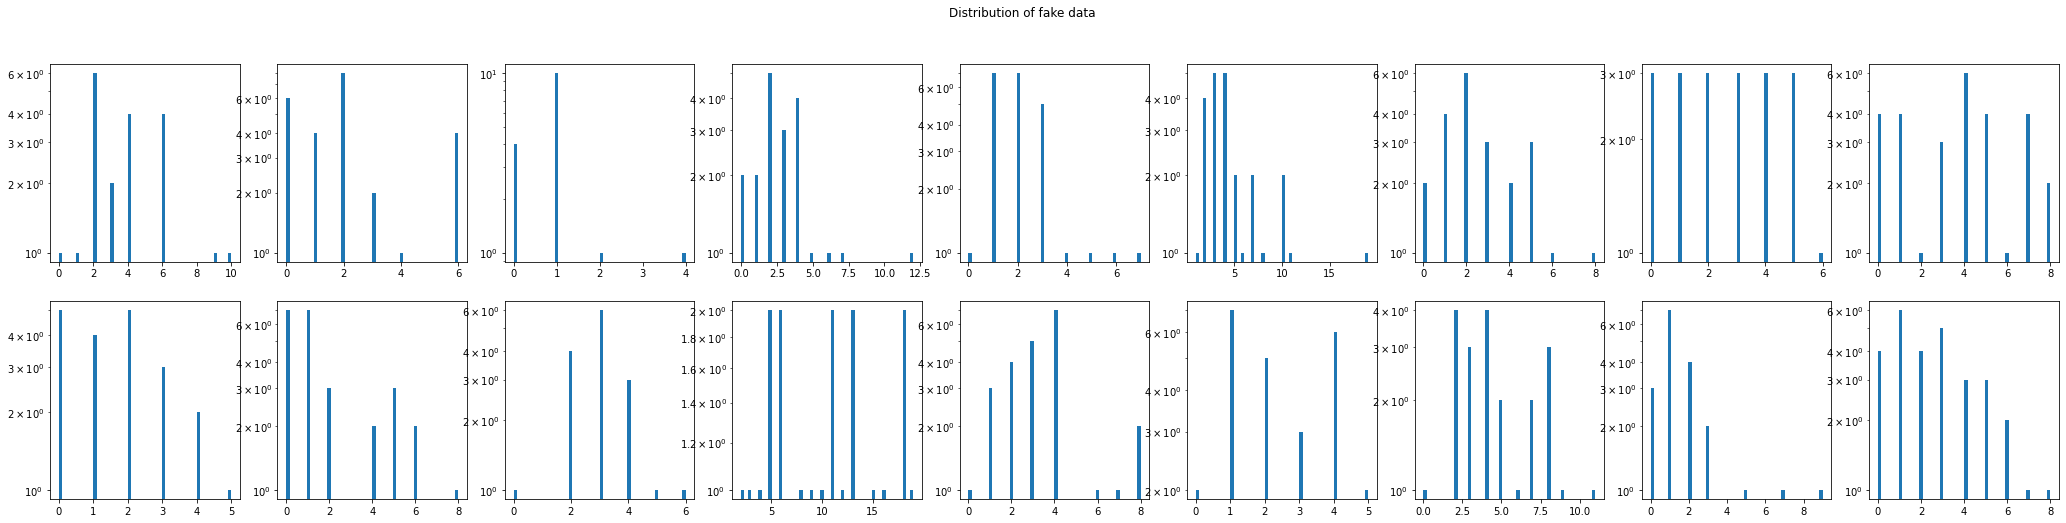

In [4]:
def plot_few_gene_hist(counts_ng, cell_types_n, ncols=4):
    assert counts_ng.shape[0] == cell_types_n.shape[0]
    ctypes = torch.unique(cell_types_n)
    genes = counts_ng.shape[-1]
    
    nrows = genes
    ncols = len(ctypes)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

    for r in range(genes):
        tmp = counts_ng[:,r]
        for c, c_type in enumerate(ctypes):
            tmp2 = tmp[cell_types_n == c_type]
            _ = axes[r,c].hist(tmp2, bins=50, density=False, log=True)
    plt.close()
    return fig

counts_ng = fake_data["counts_ng"]
cell_types_n = fake_data["cell_type_ids_n"]
fig = plot_few_gene_hist(counts_ng[:,:2], cell_types_n, ncols=3)
_ = fig.suptitle("Distribution of fake data")
fig

### Package the fake data for the models

In [18]:
fake_dataset = {
    "counts" : fake_data["counts_ng"],
    "cell_type_codes" : fake_data["cell_type_ids_n"],
    "other_covariates" : fake_data["X_nl"]
}                               

# Model 1 (no priors)

In [46]:
def model_poisson_log_normal_v1(dataset, observed: bool=True):
    """ 
    This model has NO priors on the regression parameters and the noise in the rate
    """
    
    # Unpack the dataset
    counts_ng = dataset["counts"].long()
    covariates_nl = dataset['other_covariates'].float()  
    cell_type_ids_n = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = cell_type_ids_n.max().item()+1
    
    n, g = counts_ng.shape[:2]
    n, l = covariates_nl.shape[:2]
    n = cell_type_ids_n.shape[0]  
    assert isinstance(k, int) and k>0, "Got {0}".format(k)
    assert isinstance(l, int) and l>0, "Got {0}".format(l)
    assert isinstance(n, int) and n>0, "Got {0}".format(n)
    assert isinstance(g, int) and g>0, "Got {0}".format(g)
    
    if torch.cuda.is_available(): 
        covariates_nl = covariates_nl.cuda()
        cell_type_ids_n = cell_type_ids_n.cuda()
        counts_ng = counts_ng.cuda()
    device = covariates_nl.device
    
    # Define the parameter for the model prior
    alpha0_loc = -6.0
    alpha0_scale = 1E-2
    alpha_scale = 1E-2
    eps_low = 1E-4
    eps_high = 1E-1
    
    # Define the gene and cell plates. It make sense to subsample only gene and cells.
    cell_plate = pyro.plate("cells", size=n, dim=-3, device=device, subsample_size=None)
    gene_plate = pyro.plate("genes", size=g, dim=-1, device=device, subsample_size=None) 
    
    # define the parameters
    eps_g = pyro.param("eps_g", 
                       dist.Uniform(low=eps_low, high=eps_high).sample(sample_shape=[g]), 
                       constraint=constraints.interval(eps_low, eps_high))
    alpha0_k1g = pyro.param("alpha0", 
                            dist.Normal(loc=alpha0_loc, scale=alpha0_scale).sample(sample_shape=[k,1,g]))
    alpha_klg = pyro.param("alpha", 
                           dist.Normal(loc=0.0, scale=alpha_scale).sample(sample_shape=[k,l,g]))
    eps_n1g = pyro.param("eps_n1g", dist.Normal(loc=0, scale=eps_g).sample(sample_shape=[n,1]))
        
    assert eps_g.shape == torch.Size([g]), "Got {0}".format(eps_g.shape)
    assert alpha0_k1g.shape == torch.Size([k,1,g]), "Got {0}".format(alpha0_k1g.shape)
    assert alpha_klg.shape == torch.Size([k,l,g]), "Got {0}".format(alpha_klg.shape)
    assert eps_n1g.shape == torch.Size([n,1,g]), "Got {0}".format(eps_n1g.shape)
    
    
    with cell_plate as ind_n:
        cell_ids_sub_n = cell_type_ids_n[ind_n]
        alpha0_n1g = alpha0_k1g[cell_ids_sub_n]
        alpha_nlg = alpha_klg[cell_ids_sub_n]
        covariate_sub_nl1 = covariates_nl[cell_ids_sub_n].unsqueeze(dim=-1)
        log_mu_n1g = alpha0_n1g + torch.sum(covariate_sub_nl1 * alpha_nlg, dim=-2, keepdim=True)
        total_umi_n11 = counts_ng[ind_n].sum(dim=-1, keepdim=True).unsqueeze(dim=-1)
        eps_sub_n1g = eps_n1g[ind_n]
        
        with gene_plate as ind_g: 
            mu_n1g = (log_mu_n1g[...,ind_g] + eps_sub_n1g[..., ind_g]).exp()
            rate_n1g = mu_n1g * total_umi_n11 
            
            pyro.sample("counts", dist.Poisson(rate_n1g), 
                        obs=counts_ng[ind_n, None][...,ind_g] if observed else None)

Trace Shapes:               
 Param Sites:               
        eps_g             30
       alpha0       9   1 30
        alpha       9  10 30
      eps_n1g     200   1 30
Sample Sites:               
   cells dist              |
        value         200  |
     log_prob              |
   genes dist              |
        value          30  |
     log_prob              |
  counts dist 200   1  30  |
        value 200   1  30  |
     log_prob 200   1  30  |


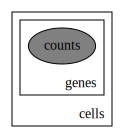

In [47]:
def guide_poisson_log_normal_v1(*args, **kargs):
    pass

trace = poutine.trace(model_poisson_log_normal_v1).get_trace(fake_dataset)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

pyro.render_model(model_poisson_log_normal_v1, model_kwargs={"dataset": fake_dataset})

# MODEL 2 (with priors)

In [48]:
def model_poisson_log_normal_v2(dataset, observed: bool = True):
    """ 
    This model has priors on the regression parameters and the noise in the rate
    """
    
    # Unpack the dataset
    counts_ng = dataset["counts"].long()
    covariates_nl = dataset['other_covariates'].float()  
    cell_type_ids_n = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = cell_type_ids_n.max().item()+1
    
    n, g = counts_ng.shape[:2]
    n, l = covariates_nl.shape[:2]
    n = cell_type_ids_n.shape[0]  
    assert isinstance(k, int) and k>0, "Got {0}".format(k)
    assert isinstance(l, int) and l>0, "Got {0}".format(l)
    assert isinstance(n, int) and n>0, "Got {0}".format(n)
    assert isinstance(g, int) and g>0, "Got {0}".format(g)
    
    if torch.cuda.is_available(): 
        covariates_nl = covariates_nl.cuda()
        cell_type_ids_n = cell_type_ids_n.cuda()
        counts_ng = counts_ng.cuda()
    device = covariates_nl.device
      
    # Define the parameter for the model prior
    alpha0_loc = -6.0
    alpha0_scale = 1E-2
    alpha_scale = 1E-2
    eps_low = 1E-4
    eps_high = 1E-1
    
    # Define the gene and cell plates. It make sense to subsample only gene and cells.
    cell_plate = pyro.plate("cells", size=n, dim=-3, device=device, subsample_size=None) 
    cell_types_plate = pyro.plate("cell_types", size=k, dim=-3, device=device)
    covariate_plate = pyro.plate("covariate", size=l, dim=-2, device=device)
    gene_plate = pyro.plate("genes", size=g, dim=-1, device=device, subsample_size=None) 
    
    with gene_plate as ind_g: 
        eps_g = pyro.sample("eps_g", dist.Uniform(low=eps_low, high=eps_high))
        with cell_types_plate:
            alpha0_k1g = pyro.sample("alpha0", dist.Normal(loc=alpha0_loc, scale=alpha0_scale))
            with covariate_plate:
                alpha_klg = pyro.sample("alpha", dist.Normal(loc=0, scale=alpha_scale))
    
    # assert eps_g.shape == torch.Size([len(ind_g)])
    # assert alpha0_k1g.shape == torch.Size([k,1,len(ind_g)]), "Got {0}".format(alpha0_k1g.shape)
    # assert alpha_klg.shape == torch.Size([k,l,len(ind_g)]), "Got {0}".format(alpha_klg.shape)
    
    with cell_plate as ind_n:
        cell_ids_sub_n = cell_type_ids_n[ind_n]
        alpha0_n1g = alpha0_k1g[cell_ids_sub_n]
        alpha_nlg = alpha_klg[cell_ids_sub_n]
        covariate_sub_nl1 = covariates_nl[cell_ids_sub_n].unsqueeze(dim=-1)
        log_mu_n1g = alpha0_n1g + torch.sum(covariate_sub_nl1 * alpha_nlg, dim=-2, keepdim=True)
        total_umi_n11 = counts_ng[ind_n].sum(dim=-1, keepdim=True).unsqueeze(dim=-1)
    
        assert alpha0_n1g.shape == torch.Size([len(ind_n), 1, len(ind_g)]), "Got {0}".format(alpha0_n1g.shape)
        assert alpha0_n1g.shape == torch.Size([len(ind_n), 1, len(ind_g)]), "Got {0}".format(alpha0_n1g.shape)
        assert total_umi_n11.shape == torch.Size([len(ind_n), 1, 1]), "Got {0}".format(total_umi_n11.shape)

        with gene_plate as ind_g: 
            eps_n1g = pyro.sample("eps_n1g", dist.Normal(loc=0, scale=eps_g))
            mu_n1g = (log_mu_n1g + eps_n1g).exp()
            rate_n1g = mu_n1g * total_umi_n11 
            pyro.sample("counts", dist.Poisson(rate_n1g), 
                        obs=counts_ng[ind_n, None][...,ind_g] if observed else None)

  Trace Shapes:             
   Param Sites:             
  Sample Sites:             
     cells dist            |
          value        200 |
       log_prob            |
cell_types dist            |
          value          9 |
       log_prob            |
 covariate dist            |
          value         10 |
       log_prob            |
     genes dist            |
          value         30 |
       log_prob            |
     eps_g dist         30 |
          value         30 |
       log_prob         30 |
    alpha0 dist   9  1  30 |
          value   9  1  30 |
       log_prob   9  1  30 |
     alpha dist   9 10  30 |
          value   9 10  30 |
       log_prob   9 10  30 |
   eps_n1g dist 200  1  30 |
          value 200  1  30 |
       log_prob 200  1  30 |
    counts dist 200  1  30 |
          value 200  1  30 |
       log_prob 200  1  30 |


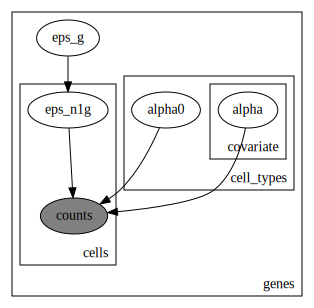

In [49]:
guide_poisson_log_normal_v2 = pyro.infer.autoguide.AutoDelta(model_poisson_log_normal_v2)

trace = poutine.trace(model_poisson_log_normal_v2).get_trace(fake_dataset)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

pyro.render_model(model_poisson_log_normal_v2, model_kwargs={"dataset": fake_dataset})

# Train both models

In [50]:
def train(model, guide, model_args=[], model_kargs=dict(), lr=0.005, n_steps=2500, print_frequency=50, clear_param_store=True):
    if clear_param_store:
        pyro.clear_param_store()
    
    adam = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    for i in range(n_steps):
        loss = svi.step(*model_args, **model_kargs)
        if i % print_frequency == 0:
            print('[iter {}]  loss: {:.4f}'.format(i, loss))

In [66]:
train(model_poisson_log_normal_v1, guide_poisson_log_normal_v1, 
      model_kargs = {"dataset": fake_dataset, "observed": True}, 
      n_steps=5, print_frequency=1,
     clear_param_store=True)

pyro.get_param_store().save(filename="params_model_v1.pt")

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

[iter 0]  loss: 60346.1289
[iter 1]  loss: 58999.6172
[iter 2]  loss: 57659.8164
[iter 3]  loss: 56327.2578
[iter 4]  loss: 55002.4961
eps_g torch.Size([30])
alpha0 torch.Size([9, 1, 30])
alpha torch.Size([9, 10, 30])
eps_n1g torch.Size([200, 1, 30])


In [65]:
train(model_poisson_log_normal_v2, guide_poisson_log_normal_v2, 
      model_kargs = {"dataset": fake_dataset, "observed": True}, 
      n_steps=5, print_frequency=1,
      clear_param_store=True)

pyro.get_param_store().save(filename="params_model_v2.pt")

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

[iter 0]  loss: 34633.9176
[iter 1]  loss: 34417.5843
[iter 2]  loss: 34325.8355
[iter 3]  loss: 34287.6612
[iter 4]  loss: 34249.7669
AutoDelta.eps_g torch.Size([30])
AutoDelta.alpha0 torch.Size([9, 1, 30])
AutoDelta.alpha torch.Size([9, 10, 30])
AutoDelta.eps_n1g torch.Size([200, 1, 30])


# PLOT THE REDICTION VS THE REAL

In [53]:
from pyro.infer import Predictive

In [70]:
pyro.get_param_store().load(filename="params_model_v1.pt")
predictive1 = Predictive(model_poisson_log_normal_v1, guide=guide_poisson_log_normal_v1, num_samples=2, 
                        return_sites={"counts"})
samples1 = predictive1.get_samples(fake_dataset, observed=False)
for k, v in samples1.items():
    print(f"{k}: {tuple(v.shape)}")

counts: (2, 200, 1, 30)


In [71]:
pyro.get_param_store().load(filename="params_model_v2.pt")
predictive2 = Predictive(model_poisson_log_normal_v2, guide=guide_poisson_log_normal_v2, num_samples=2, 
                        return_sites={"counts"})
samples2 = predictive2.get_samples(fake_dataset, observed=False)
for k, v in samples2.items():
    print(f"{k}: {tuple(v.shape)}")

counts: (2, 200, 1, 30)


In [72]:
assert torch.any(samples1["counts"][0] != samples1["counts"][1])
assert torch.any(samples2["counts"][0] != samples2["counts"][1])

In [73]:
cell_types_n = fake_dataset["cell_type_codes"]
true_counts_ng = fake_dataset['counts']
pred1_counts_ng = samples1["counts"][0].squeeze()
pred2_counts_ng = samples2["counts"][0].squeeze()

print(cell_types_n.shape, true_counts_ng.shape, pred1_counts_ng.shape, pred2_counts_ng.shape)

torch.Size([200]) torch.Size([200, 30]) torch.Size([200, 30]) torch.Size([200, 30])


In [74]:
fig0 = plot_few_gene_hist(true_counts_ng[:,:2], cell_types_n, ncols=3)
fig1 = plot_few_gene_hist(pred1_counts_ng[:,:2], cell_types_n, ncols=3)
fig2 = plot_few_gene_hist(pred2_counts_ng[:,:2], cell_types_n, ncols=3)

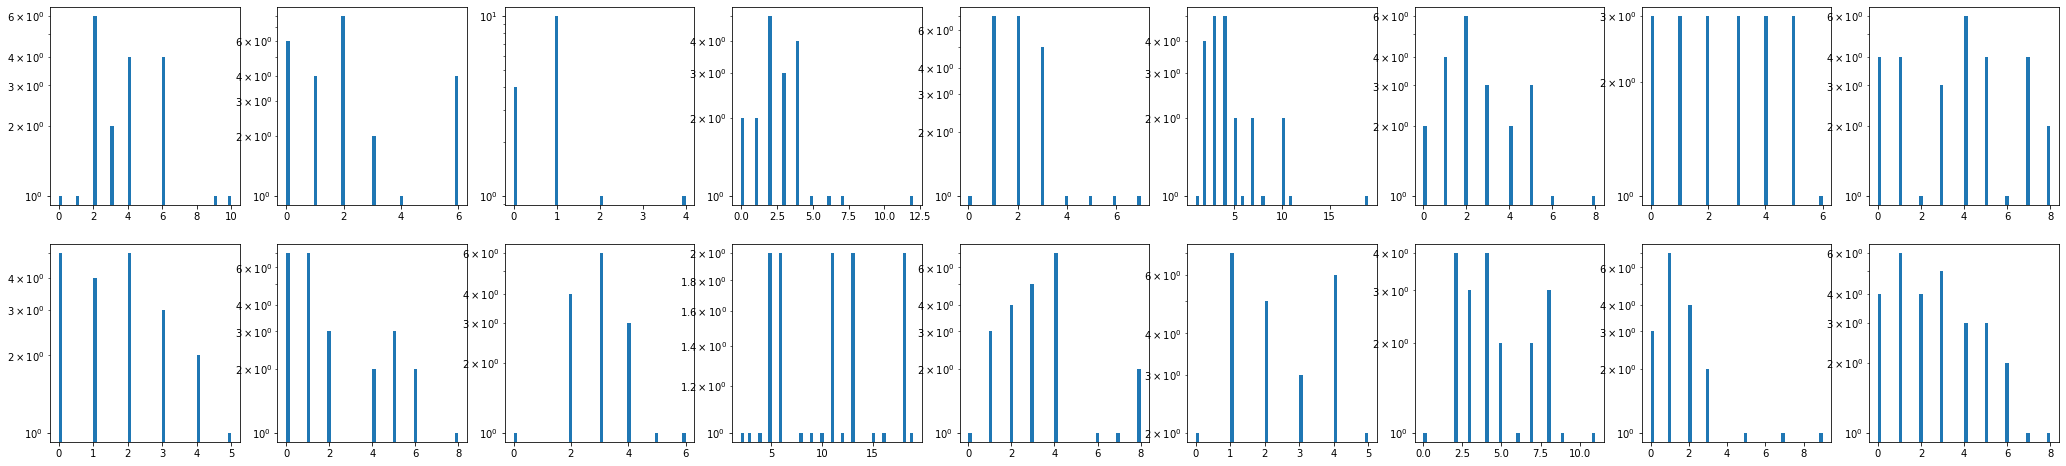

In [75]:
fig0

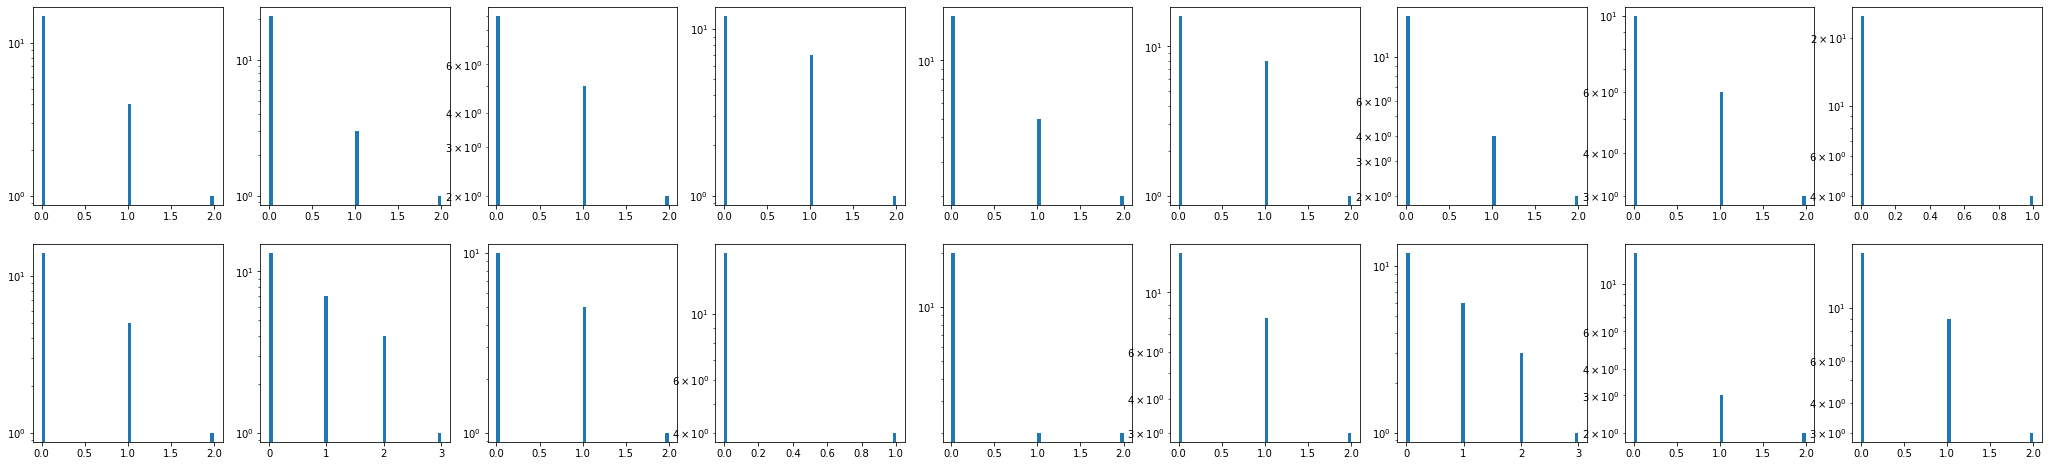

In [76]:
fig1

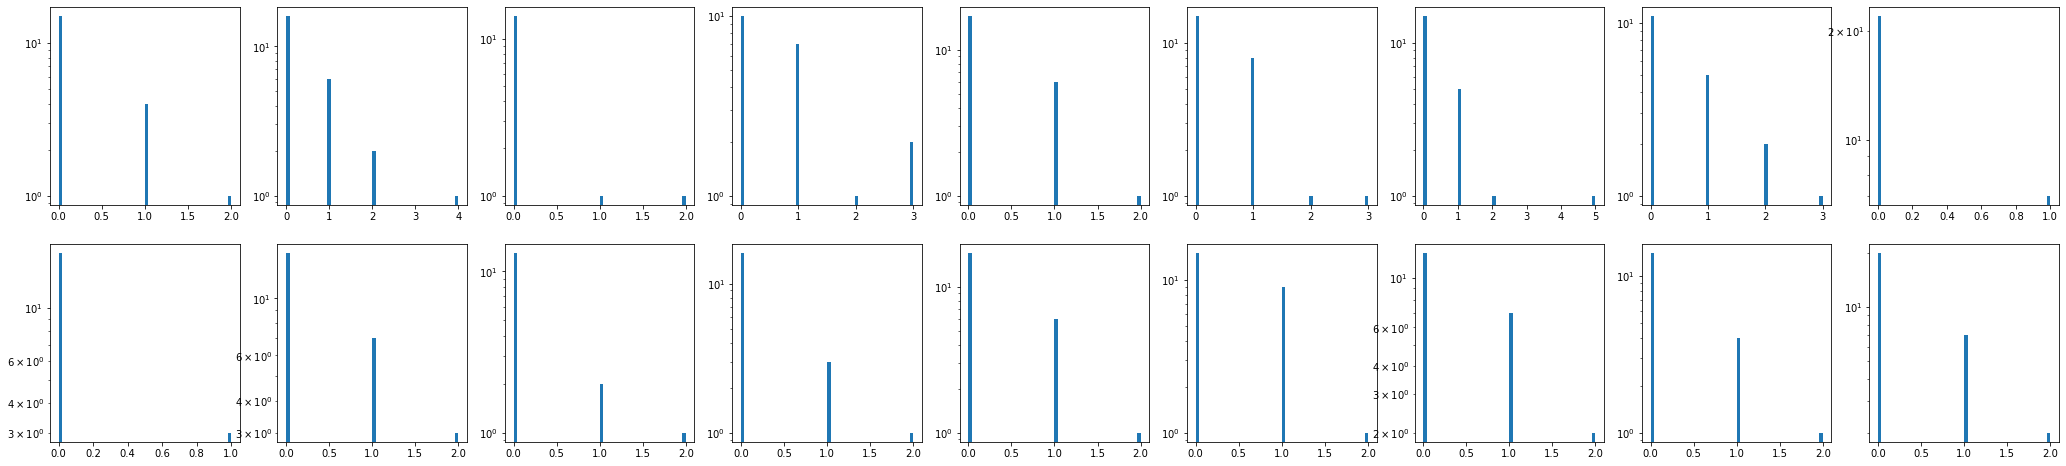

In [77]:
fig2